In [2]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torchvision
import torch.utils.data as Data
import torch.nn.functional as func
import torch.nn.init as Init

In [3]:
BATCH_SIZE = 100
EPOCH = 75
gpu = torch.cuda.FloatTensor
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',    # 保存或者提取位置
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(),    # 转换 PIL.Image or numpy.ndarray 成
                                                    # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
    download=False,          # 没下载就下载, 下载了就不用再下了
)

In [5]:
train_loader = Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)

In [21]:
class VAE(nn.Module):
    def __init__(self,batch_size = BATCH_SIZE, trans_func = nn.Softplus):
        super(VAE,self).__init__()
        self.trans_func = trans_func
        self.batch_size = batch_size
        #encoder
        self.en_h1 = nn.Linear(784,500)
        #Init.xavier_uniform(self.en_h1.weight,gain=1.73)
        Init.xavier_normal(self.en_h1.weight,gain=1.73)
        self.en_h2 = nn.Linear(500,500)
        #Init.xavier_uniform(self.en_h2.weight,gain=1.73)
        Init.xavier_normal(self.en_h2.weight,gain=1.73)
        self.out_mean = nn.Linear(500,20)
        #Init.xavier_uniform(self.out_mean.weight,gain=1.73)
        Init.xavier_normal(self.out_mean.weight,gain=1.73)
        self.out_std = nn.Linear(500,20)
        #Init.xavier_uniform(self.out_std.weight,gain=1.73)
        Init.xavier_normal(self.out_std.weight,gain=1.73)
        #decoder
        self.de_h1 = nn.Linear(20,500)
        #Init.xavier_uniform(self.de_h1.weight,gain=1.73)
        Init.xavier_normal(self.de_h1.weight,gain=1.73)
        self.de_h2 = nn.Linear(500,500)
        #Init.xavier_uniform(self.de_h2.weight,gain=1.73)
        Init.xavier_normal(self.de_h2.weight,gain=1.73)
        self.out_rec = nn.Linear(500,784)
        #Init.xavier_uniform(self.out_rec.weight,gain=1.73)
        Init.xavier_normal(self.out_rec.weight,gain=1.73)
    
    def _encoder(self,x):
        #x = x.view(x.size(0),-1)
        layer_1 = func.softplus(self.en_h1(x))
        pass
        layer_2 = func.softplus(self.en_h2(layer_1))
        pass
        z_mean = self.out_mean(layer_2)
        pass
        z_log_sigma_sq = self.out_std(layer_2)
        #pass
        return (z_mean,z_log_sigma_sq)
    
    def _decoder(self,z):
        layer_1 = func.softplus(self.de_h1(z))
        pass
        #print(layer_1[0])
        layer_2 = func.softplus(self.de_h2(layer_1))
        #print(layer_2[0][0:5])
        pass
        x_rec = func.sigmoid(self.out_rec(layer_2))
        #pass
        #print(x_rec[0])
        return x_rec
    
    def forward(self,x):
        self.z_mean,self.z_sigma = self._encoder(x)
        #print(z_mean)
        eps = Variable(torch.Tensor(self.batch_size,20).normal_(0,1).type(torch.cuda.FloatTensor))
        #print(eps)
        z = torch.add(torch.mul(torch.sqrt(torch.exp(self.z_sigma)),eps),self.z_mean)
        #print(z[0])
        #z = Variable(z)
        self.x_rec = self._decoder(z)
        return self.x_rec,self.z_mean,self.z_sigma
    
    def transform(self,x):
        return self._encoder(x)
    def reconstruct(self,x):
        return forward(x)
    def generate(self,z_mu = None):
        if z_mu is None:
            n_z = 20
            z_mu = Variable(torch.Tensor(self.batch_size,n_z).normal_().type(gpu))
        return self._decoder(z_mu)
    
    def cost(self,y):
        x =self.x_rec
        generative_loss = -torch.sum(torch.mul(y, torch.log(1e-10 + x))
                           + torch.mul((1-y) , torch.log(1e-10 + 1 - x)),1)
        latent_loss = -0.5 * torch.sum(1 + self.z_sigma 
                                           - torch.pow(self.z_mean,2) 
                                           - torch.exp(self.z_sigma), 1)
        loss = torch.mean(generative_loss + latent_loss)
        return loss


In [22]:

class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss,self).__init__()
        
    def forward(self,x,y,z_mean,z_sigma):
        z_mean,z_sigma = vae.transform(y)
        generative_loss = -torch.sum(torch.mul(y, torch.log(1e-10 + x))
                           + torch.mul((1-y) , torch.log(1e-10 + 1 - x)),1)
        #print('gL',generative_loss[0])
        #print(generative_loss[0])
        #generative_func = nn.CrossEntropyLoss()
        #generative_loss = generative_func(x,y)
        
        latent_loss = -0.5 * torch.sum(1 + z_sigma 
                                           - torch.pow(z_mean,2) 
                                           - torch.exp(z_sigma), 1)
        #print('gL',generative_loss[0])
        #print('gl',generative_loss)
        #print('ll',latent_loss)
        loss = torch.mean(generative_loss + latent_loss)
        #loss = torch.mean( generative_loss)
        #loss = torch.mean(latent_loss)
        return loss


In [23]:
reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x.view(-1, 784))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD


In [24]:
gpu = torch.cuda.FloatTensor
vae = VAE(BATCH_SIZE)
vae_gpu = vae.type(gpu)
loss_func = VAELoss().type(gpu)
loss_func2 = nn.MSELoss().type(gpu)
optimizer = torch.optim.Adam(vae.parameters(),lr = 0.001)

In [27]:
for epoch in range(EPOCH):
    avg_cost = 0
    total_batch = int(n_samples / BATCH_SIZE)
    for step,(x,_) in enumerate(train_loader):
        #batch_xs, _ = mnist.train.next_batch(BATCH_SIZE)
        #print(batch_xs[0])
        #xs = torch.from_numpy(batch_xs)
        #x = Variable(xs.type(gpu))
        x = Variable(x.type(gpu)).view(x.size(0),-1)
        x_rec,z_mean,z_sigma = vae_gpu.forward(x)
        
        #print(x_rec[0])
        #print(x[0])
        #print(z_mean,z_sigma)
        
        loss = loss_func(x_rec,x,z_mean,z_sigma)
        #loss = loss_function(x_rec,x,z_mean,z_sigma)
        avg_cost += loss.data[0]/n_samples*BATCH_SIZE
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #break
    if epoch%5 == 0:
        print("Epoch:", '%04d' % (epoch+1), 
                  "cost=%04f"% avg_cost)
    #if epoch>=10:
    #   print(x_rec[0].data.cpu().numpy().reshape(28,28))
        #print(torch.sum(vae_gpu.out_rec.weight)) 
        #break
    #break

Epoch: 0001 cost=111.309556
Epoch: 0006 cost=110.184042
Epoch: 0011 cost=110.090594
Epoch: 0016 cost=110.505770
Epoch: 0021 cost=109.671571
Epoch: 0026 cost=108.554440
Epoch: 0031 cost=107.620226
Epoch: 0036 cost=106.841128
Epoch: 0041 cost=106.252918
Epoch: 0046 cost=105.763919
Epoch: 0051 cost=105.240177
Epoch: 0056 cost=104.877553
Epoch: 0061 cost=104.546688
Epoch: 0066 cost=104.203347
Epoch: 0071 cost=103.921333


In [28]:
x = vae_gpu.generate(z_mu=None)
print(x[0])

Variable containing:
 6.7181e-12
 2.3586e-11
 1.5434e-11
 6.3915e-12
 2.1540e-11
 1.0199e-11
 9.3319e-12
 7.9396e-12
 8.2870e-12
 5.6047e-12
 8.8247e-12
 1.1067e-11
 3.3314e-13
 7.5592e-14
 2.3398e-17
 5.2836e-14
 9.2247e-12
 7.8502e-12
 7.5824e-12
 6.4321e-12
 9.8739e-12
 6.5190e-12
 1.8364e-11
 5.7937e-12
 8.6800e-12
 9.7205e-12
 3.8590e-12
 1.4916e-11
 7.0795e-11
 1.3014e-11
 4.4284e-12
 1.3545e-11
 1.0724e-13
 1.9123e-14
 3.4565e-16
 2.8348e-17
 8.0259e-17
 1.6400e-15
 1.7985e-19
 4.8823e-20
 2.6821e-20
 2.6415e-18
 4.6723e-21
 2.8645e-18
 7.0672e-14
 4.0428e-15
 1.6826e-19
 7.0832e-17
 1.9208e-15
 1.7852e-17
 4.1438e-19
 4.0879e-16
 1.9644e-11
 9.6231e-12
 7.9241e-12
 1.4613e-11
 1.8939e-11
 9.5117e-12
 6.3537e-17
 3.4452e-19
 2.5499e-20
 9.2936e-15
 1.7784e-20
 2.3067e-18
 6.2240e-16
 3.4558e-18
 2.2109e-18
 4.5716e-20
 1.6563e-23
 3.8278e-23
 1.2452e-26
 2.4031e-25
 8.6547e-23
 9.9466e-28
 3.2674e-29
 1.3487e-35
 7.4637e-35
 5.1783e-28
 1.3881e-21
 6.6850e-24
 9.5861e-21
 4.0875

In [41]:
x_sample = mnist.test.next_batch(100)[0]
xs = torch.from_numpy(x_sample)
x = Variable(xs.type(gpu))
x_reconstruct,_,_ = vae(x)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].data.cpu().numpy().reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

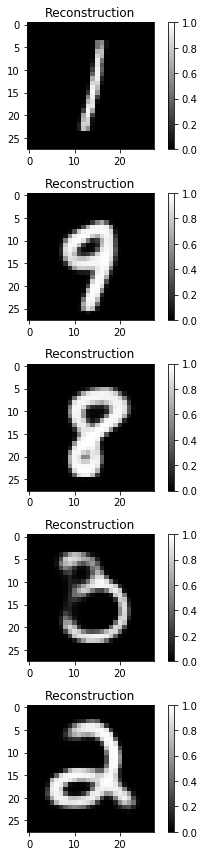

In [42]:
plt.show()